# ASCAT_CCF calculation in lung sample

In [1]:
# Needed basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook

In [2]:
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [3]:
# Import filtered mutation files 
common_mut_df = pd.read_csv('/workspace/projects/sjd_melos/MAFs_tables/Lung_List_common_mutations_callers.tsv.gz', sep="\t", header=0)

# Import purity value and copy number from ASCAT files
ascat_purity_df = pd.read_csv('/workspace/projects/sjd_melos/var_call_output/sarek_results/variant_calling/ascat/AX4941_vs_AB9766/AX4941_vs_AB9766.purityploidy.txt', sep="\t", header=0)
ascat_cnv_df = pd.read_csv('/workspace/projects/sjd_melos/var_call_output/sarek_results/variant_calling/ascat/AX4941_vs_AB9766/AX4941_vs_AB9766.cnvs.txt', sep="\t", header=0)

In [4]:
common_mut_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_DP,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=40,144|18,33;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.177e-03:124:33,0:29,0:124,0:0|1:10...",...,124,51,0,60,124,0.459459,SNV,Mutect_Strelka,sarcoma_lung,chr1_104188_C_A
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=81,70|44,36;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,126,80,0,25,126,0.761905,SNV,Mutect_Strelka,sarcoma_lung,chr1_843320_G_A
2,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=114,133|12,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,153,42,0,94,153,0.308824,SNV,Mutect_Strelka,sarcoma_lung,chr1_1118520_C_T
3,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=72,93|44,38;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,123,82,0,42,123,0.661290,SNV,Mutect_Strelka,sarcoma_lung,chr1_1136548_G_T
4,chr1,1182738,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=126,126|27,25...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:167,0:5.950e-03:167:85,0:68,0:165,0:84,83,0,0",...,167,52,0,85,167,0.379562,SNV,Mutect_Strelka,sarcoma_lung,chr1_1182738_C_T


In [5]:
# Extract purity value from table, note that this value is the Aberrant Cell Fraction
purity = ascat_purity_df['AberrantCellFraction']
purity

0    0.69
Name: AberrantCellFraction, dtype: float64

## 1/ Processing ASCAT CNV FILE

In [6]:
ascat_cnv_df.head()

,chr,startpos,endpos,nMajor,nMinor
0,1,809641,14840507,2,0
1,1,14842839,15712384,4,0
2,1,15715111,21695683,2,0
3,1,21707894,26321837,2,1
4,1,26328446,27367871,4,2


In [7]:
# Calculate copy number (CN) from cnv files and add it as new column (CN is the sum of nMajor and nMinor columns)
ascat_cnv_df[['nMajor', 'nMinor']] = ascat_cnv_df[['nMajor', 'nMinor']].astype(int) # convert so it is operable, not string
ascat_cnv_df['CN'] = ascat_cnv_df['nMajor'] + ascat_cnv_df['nMinor'] # CN is the sum of nMajor and nMinor alleles
ascat_cnv_df.head()

,chr,startpos,endpos,nMajor,nMinor,CN
0,1,809641,14840507,2,0,2
1,1,14842839,15712384,4,0,4
2,1,15715111,21695683,2,0,2
3,1,21707894,26321837,2,1,3
4,1,26328446,27367871,4,2,6


In [8]:
# Add "chr" in chr column to homogenize nomenclature as common_mut_df 
ascat_cnv_df['chr'] = ascat_cnv_df['chr'].apply(lambda x: 'chr'+str(x))
ascat_cnv_df.head()

,chr,startpos,endpos,nMajor,nMinor,CN
0,chr1,809641,14840507,2,0,2
1,chr1,14842839,15712384,4,0,4
2,chr1,15715111,21695683,2,0,2
3,chr1,21707894,26321837,2,1,3
4,chr1,26328446,27367871,4,2,6


In [9]:
# Rename columns and drop unnecessary columns
ascat_cnv_df = ascat_cnv_df.rename(columns={'chr':'chrom','startpos':'start', 'endpos':'end'})
ascat_cnv_df = ascat_cnv_df.drop(columns=['nMajor','nMinor'])
ascat_cnv_df.head()

,chrom,start,end,CN
0,chr1,809641,14840507,2
1,chr1,14842839,15712384,4
2,chr1,15715111,21695683,2
3,chr1,21707894,26321837,3
4,chr1,26328446,27367871,6


## 2/ Add CN from ASCAT CN file to common mutations df with Pybedtools

In [10]:
# Pybedtools package: see https://daler.github.io/pybedtools/main.html for documentation
# installed in the conda environment through terminal with: pip install pybedtools
# The path of BedTools has been modified in bashrc file to be able to execute pybedtools globally.
# Import package
import pybedtools

In [11]:
# To use pybedtools POS column of common_mut_df should have another coordenate like end position. To do so, duplicate the information of POS column and add +1:

mutations_df = pd.DataFrame({
    'CHROM': common_mut_df['CHROM'],
    'start': common_mut_df['POS'],
    'end': common_mut_df['POS'] + 1, # duplicate this column so it is considered a "bed file"
    'REF': common_mut_df['REF'],
    'ALT': common_mut_df['ALT']   
}) # take only necessary columns of common_mut_df to convert as a "bed" coordinate file

mutations_df

,CHROM,start,end,REF,ALT
0,chr1,104188,104189,C,A
1,chr1,843320,843321,G,A
2,chr1,1118520,1118521,C,T
3,chr1,1136548,1136549,G,T
4,chr1,1182738,1182739,C,T
...,...,...,...,...,...
22120,chrY,26654389,26654390,A,G
22121,chrY,56823266,56823267,G,A
22122,chrY,56842066,56842067,CT,AC
22123,chrY,56842087,56842088,T,C


### Use ASCAT CNV FILE to intersect with mutation data

In [12]:
# Convert previous dataframes to a BedTool object so data could be processed with pybedtools
mutations_bt = pybedtools.BedTool.from_dataframe(mutations_df)
ascat_cn_bt = pybedtools.BedTool.from_dataframe(ascat_cnv_df)

In [13]:
# Use intersect method of Bedtools to intersect tables (see https://daler.github.io/pybedtools/intersections.html)
cnv_bt = ascat_cn_bt.intersect(mutations_bt) #save intersect table into a new dataframe

In [14]:
# Convert cnv bedtool object into a dataframe. 
cnv_df = cnv_bt.to_dataframe(header=None) # Note that "chrom, start, end, name" columns are by default even using "header = None".
cnv_df

,chrom,start,end,name
0,chr1,843320,843321,2
1,chr1,1118520,1118521,2
2,chr1,1136548,1136549,2
3,chr1,1182738,1182739,2
4,chr1,1192304,1192305,2
...,...,...,...,...
21881,chrX,153193034,153193035,1
21882,chrX,153635439,153635440,1
21883,chrX,153712041,153712042,1
21884,chrX,153907926,153907927,1


In [15]:
# Rename columns of cnv dataframe
cnv_df = cnv_df.rename(columns={'chrom':'CHROM','start':'POS','end':'POS2','name':'CN'})

# Drop POS2 column, which is an artificial column we created previously
cnv_df = cnv_df.drop(columns='POS2')

In [16]:
# We are loosing this number of mutations with the intersect method (?!)
len(mutations_df) - len(cnv_df)

239

## 3/ Calculate CCF

In [17]:
# Merge intersect with common_mut_df adding left indicates: use only keys from left frame, preserve key order
mutations_cnv_df = pd.merge(common_mut_df,cnv_df,how='left')

In [18]:
mutations_cnv_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=40,144|18,33;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.177e-03:124:33,0:29,0:124,0:0|1:10...",...,51,0,60,124,0.459459,SNV,Mutect_Strelka,sarcoma_lung,chr1_104188_C_A,NaN
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=81,70|44,36;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,80,0,25,126,0.761905,SNV,Mutect_Strelka,sarcoma_lung,chr1_843320_G_A,2.0
2,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=114,133|12,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,42,0,94,153,0.308824,SNV,Mutect_Strelka,sarcoma_lung,chr1_1118520_C_T,2.0
3,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=72,93|44,38;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,82,0,42,123,0.661290,SNV,Mutect_Strelka,sarcoma_lung,chr1_1136548_G_T,2.0
4,chr1,1182738,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=126,126|27,25...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:167,0:5.950e-03:167:85,0:68,0:165,0:84,83,0,0",...,52,0,85,167,0.379562,SNV,Mutect_Strelka,sarcoma_lung,chr1_1182738_C_T,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22120,chrY,26654389,.,A,G,327,PASS,RC=GGAGAGGAAT;RC_IDX=6;RC_LF=GTAATGGAGT;RC_NM=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:57,0:0:58:2084,0:63,0:0,0,0,0,0,57,58:0:...",...,19,0,15,57,0.559000,SNV,Strelka_SAGE,sarcoma-lung,chrY_26654389_A_G,NaN
22121,chrY,56823266,.,G,A,314,PASS,LPS=5879;LPS_RC=16;RC=CAATTTTC;RC_IDX=2;RC_LF=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:460,0:0:460:14466,0:491,0:0,0,0,0,0,460,...",...,37,0,398,460,0.085000,SNV,Mutect_SAGE,sarcoma-lung,chrY_56823266_G_A,NaN
22122,chrY,56842066,.,CT,AC,1241,PASS,LPS=5882;LPS_RC=57;RC=ACACACAG;RC_IDX=2;RC_LF=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:290,0:0:290:9437,0:306,0:0,0,0,0,0,290,2...",...,66,0,134,290,0.330000,MNV,Mutect_SAGE,sarcoma-lung,chrY_56842066_CT_AC,NaN
22123,chrY,56842087,.,T,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=213,218|33,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:295,0:3.303e-03:295:143,0:125,0:295,0:1|0:...",...,63,0,136,295,0.316583,SNV,Mutect_Strelka,sarcoma_lung,chrY_56842087_T_C,NaN


In [19]:
# Check in CN column which mutations have non NaN values. Note that returns the same number of rows of cnv_df length.
nan_values = mutations_cnv_df[~mutations_cnv_df['CN'].isna()]
nan_values

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=81,70|44,36;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,80,0,25,126,0.761905,SNV,Mutect_Strelka,sarcoma_lung,chr1_843320_G_A,2.0
2,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=114,133|12,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,42,0,94,153,0.308824,SNV,Mutect_Strelka,sarcoma_lung,chr1_1118520_C_T,2.0
3,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=72,93|44,38;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,82,0,42,123,0.661290,SNV,Mutect_Strelka,sarcoma_lung,chr1_1136548_G_T,2.0
4,chr1,1182738,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=126,126|27,25...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:167,0:5.950e-03:167:85,0:68,0:165,0:84,83,0,0",...,52,0,85,167,0.379562,SNV,Mutect_Strelka,sarcoma_lung,chr1_1182738_C_T,2.0
5,chr1,1192304,.,A,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=91,75|43,38;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:130,0:7.653e-03:130:65,0:61,0:128,0:75,55,0,0",...,81,0,36,130,0.692308,SNV,Mutect_Strelka,sarcoma_lung,chr1_1192304_A_T,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22003,chrX,153193034,.,C,CT,260,PASS,LPS=5871;LPS_RC=14;MH=T;RC=TTCTTTTTTTTTTG;RC_I...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:50,0:0:50:1549,0:51,0:0,0,0,0,0,50,50:0:...",...,17,0,43,50,0.283000,INDEL,Strelka_SAGE,sarcoma-lung,chrX_153193034_C_CT,1.0
22004,chrX,153635439,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=47,43|34,19;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:67,0:0.014:67:33,0:34,0:67,0:36,31,0,0",...,53,0,23,67,0.697368,SNV,Mutect_Strelka,sarcoma_lung,chrX_153635439_C_A,1.0
22005,chrX,153712041,.,T,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=80,78|6,3;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:65,0:0.015:65:26,0:35,0:63,0:32,33,0,0",...,9,0,93,65,0.088235,SNV,Mutect_Strelka,sarcoma_lung,chrX_153712041_T_A,1.0
22006,chrX,153907926,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=75,85|6,9;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:88,0:0.011:88:45,0:41,0:88,0:39,49,0,0",...,15,0,72,88,0.172414,SNV,Mutect_Strelka,sarcoma_lung,chrX_153907926_G_T,1.0


In [20]:
# Add 2 in CN with NaN values, because these positions despite were not in the cnv file are diploid
mutations_cnv_df['CN'].fillna(2, inplace=True) 

# Convert columns to float so they are operable to calculate CCF
mutations_cnv_df[['VAF','CN']] = mutations_cnv_df[['VAF','CN']].astype(float)
mutations_cnv_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=40,144|18,33;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.177e-03:124:33,0:29,0:124,0:0|1:10...",...,51,0,60,124,0.459459,SNV,Mutect_Strelka,sarcoma_lung,chr1_104188_C_A,2.0
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=81,70|44,36;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,80,0,25,126,0.761905,SNV,Mutect_Strelka,sarcoma_lung,chr1_843320_G_A,2.0
2,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=114,133|12,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,42,0,94,153,0.308824,SNV,Mutect_Strelka,sarcoma_lung,chr1_1118520_C_T,2.0
3,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=72,93|44,38;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,82,0,42,123,0.661290,SNV,Mutect_Strelka,sarcoma_lung,chr1_1136548_G_T,2.0
4,chr1,1182738,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=126,126|27,25...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:167,0:5.950e-03:167:85,0:68,0:165,0:84,83,0,0",...,52,0,85,167,0.379562,SNV,Mutect_Strelka,sarcoma_lung,chr1_1182738_C_T,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22120,chrY,26654389,.,A,G,327,PASS,RC=GGAGAGGAAT;RC_IDX=6;RC_LF=GTAATGGAGT;RC_NM=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:57,0:0:58:2084,0:63,0:0,0,0,0,0,57,58:0:...",...,19,0,15,57,0.559000,SNV,Strelka_SAGE,sarcoma-lung,chrY_26654389_A_G,2.0
22121,chrY,56823266,.,G,A,314,PASS,LPS=5879;LPS_RC=16;RC=CAATTTTC;RC_IDX=2;RC_LF=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:460,0:0:460:14466,0:491,0:0,0,0,0,0,460,...",...,37,0,398,460,0.085000,SNV,Mutect_SAGE,sarcoma-lung,chrY_56823266_G_A,2.0
22122,chrY,56842066,.,CT,AC,1241,PASS,LPS=5882;LPS_RC=57;RC=ACACACAG;RC_IDX=2;RC_LF=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:290,0:0:290:9437,0:306,0:0,0,0,0,0,290,2...",...,66,0,134,290,0.330000,MNV,Mutect_SAGE,sarcoma-lung,chrY_56842066_CT_AC,2.0
22123,chrY,56842087,.,T,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=213,218|33,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:295,0:3.303e-03:295:143,0:125,0:295,0:1|0:...",...,63,0,136,295,0.316583,SNV,Mutect_Strelka,sarcoma_lung,chrY_56842087_T_C,2.0


In [21]:
# Define a function that calculates CCF in each row from CN, purity and VAF values
def get_ccf(row):
    row = row['VAF'] * (purity * row['CN'] + (1 - purity) * 2) / purity
    return row

mutations_cnv_df['CCF'] = mutations_cnv_df.progress_apply(get_ccf, axis=1)

  0%|          | 0/22125 [00:00<?, ?it/s]

In [22]:
mutations_cnv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN,CCF
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=40,144|18,33;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.177e-03:124:33,0:29,0:124,0:0|1:10...",...,0,60,124,0.459459,SNV,Mutect_Strelka,sarcoma_lung,chr1_104188_C_A,2.0,1.331767
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=81,70|44,36;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,0,25,126,0.761905,SNV,Mutect_Strelka,sarcoma_lung,chr1_843320_G_A,2.0,2.208420
2,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=114,133|12,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,0,94,153,0.308824,SNV,Mutect_Strelka,sarcoma_lung,chr1_1118520_C_T,2.0,0.895141
3,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=72,93|44,38;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,0,42,123,0.661290,SNV,Mutect_Strelka,sarcoma_lung,chr1_1136548_G_T,2.0,1.916784
4,chr1,1182738,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=126,126|27,25...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:167,0:5.950e-03:167:85,0:68,0:165,0:84,83,0,0",...,0,85,167,0.379562,SNV,Mutect_Strelka,sarcoma_lung,chr1_1182738_C_T,2.0,1.100180


## 4/ Histograms representing CCF

In [23]:
# To represent in histogram, convert CCF values to list
ccf = mutations_cnv_df['CCF'].copy()  # Extract the 'CCF' column
ccf = pd.to_numeric(ccf, errors='coerce')  # Convert values to numeric, coerce errors
ccf

0        1.331767
1        2.208420
2        0.895141
3        1.916784
4        1.100180
           ...   
22120    1.620290
22121    0.246377
22122    0.956522
22123    0.917632
22124    0.107246
Name: CCF, Length: 22125, dtype: float64

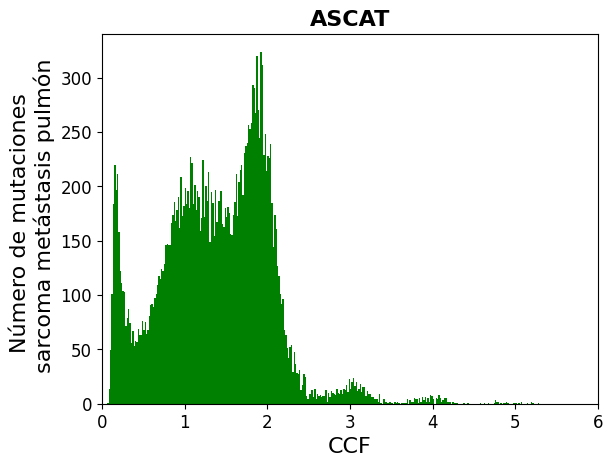

In [24]:
plt.hist(ccf.tolist(), bins = 400, color = 'green')
plt.xlim([0,6])
plt.ylabel('Número de mutaciones \n sarcoma metástasis pulmón',  fontsize=16)
plt.xlabel('CCF', fontsize=16)
plt.title('ASCAT', fontsize=16, weight ='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_ccf_ascat_lung.png',dpi=300,transparent=True, format='png', bbox_inches='tight')
plt.show(ccf.tolist())  